In [1]:
# Libraries
import torch
from torch import nn, einsum
import torch.nn.functional as f
import cv2
import numpy as np
import matplotlib.pyplot as plt
import einops
from einops import rearrange

In [2]:
# Custom Libraries 
from backbone import Backbone
from neck_bak import swin_t_neck
from head import Head
from model import Model

In [3]:
# Creating the model
backbone = Backbone(hid_dim=96, layers=[2, 2, 2, 2], heads=[3, 6, 12, 24])
neck = swin_t_neck(hid_dim=96, layers=[2,2,2,2], heads=[24, 12, 6, 3], channels=768)
head = Head(in_channels=96, num_classes=1)
model = Model(backbone, neck, head)

/home/schecter/miniconda3/envs/pikachu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 3, 896, 1600])


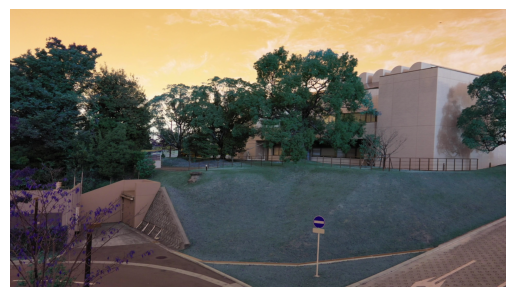

In [4]:
# Loading image
img = cv2.imread("../data/mva2023_sod4bird_train/images/00001.jpg", cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1600, 896))
data = torch.tensor(img).unsqueeze(0).float()
data = data.permute(0, 3, 1, 2)
print(data.shape)
plt.imshow(img)
plt.axis("off")
plt.show()

# This is Nishant_Trial

torch.Size([1, 3, 896, 1600])


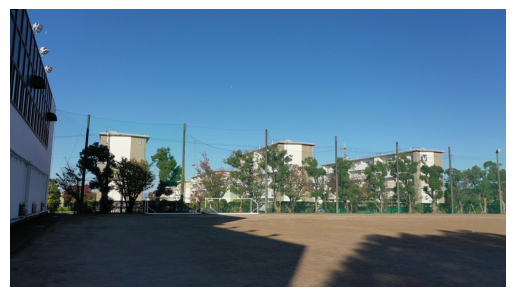

In [63]:
img = cv2.imread("/home/schecter/Downloads/07439.jpg",cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1600, 896))
data = torch.tensor(img).unsqueeze(0).float()
data = data.permute(0, 3, 1, 2)
print(data.shape)
plt.imshow(img)
plt.axis("off")
plt.show()

#These are the bounding box of all the small objects.
bbox_values = torch.tensor([[2035,1003,9,17], [795,1169,9,17], [2715,1524,9,17], [263,209,9,17], [931,844,9,17], [1621,1398,9,17]]).float()
#Other bbox values are [795,1169,9,17], [2715,1524,9,17], [263,209,9,17], [931,844,9,17], [1621,1398,9,17]


In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# data = data.to(device)

In [7]:

P_heatmap, P_width, P_height, P_offset  = model(data)

torch.Size([1, 28, 50, 768])
SWIN torch.Size([1, 28, 50, 768])
UPSAMPLE torch.Size([1, 56, 100, 384])
Exited stage 1
SWIN torch.Size([1, 56, 100, 384])
UPSAMPLE torch.Size([1, 112, 200, 192])
Exited stage 2
SWIN torch.Size([1, 112, 200, 192])
UPSAMPLE torch.Size([1, 224, 400, 96])
Exited stage 3
SWIN torch.Size([1, 224, 400, 96])
Exited stage 4
torch.Size([1, 96, 224, 400])
1


In [8]:
P_heatmap = einops.rearrange(P_heatmap, 'b c h w -> h (w c b)')
P_width = einops.rearrange(P_width, 'b c h w -> h (w c b)')
P_height = einops.rearrange(P_height, 'b c h w -> h (w c b)')
P_offset = einops.rearrange(P_offset, 'b c h w -> (c b) h w')

In [67]:
# Genearting ground truth
def generate_heatmap(image_size, bboxs):
    heatmap = np.zeros(image_size)
    for bbox in bboxs:
        x_center = (bbox[0] + bbox[2]) / 2
        y_center = (bbox[1] + bbox[3]) / 2
        heatmap[int(y_center), int(x_center)] = 1  # Set the center of the bounding box to 1
    return heatmap

def calculate_width_height(bbox):
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    return width, height

def calculate_offset(image_size, bbox):
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2
    offset_x = x_center / image_size[1]
    offset_y = y_center / image_size[0]
    return offset_x, offset_y

def generate_ground_truth(image_size, bbox):
    heatmap = generate_heatmap(image_size, bbox)
    # width, height = calculate_width_height(bbox)
    # offset_x, offset_y = calculate_offset(image_size, bbox)
    # return [torch.tensor(x) for x in [heatmap, width, height, (offset_x, offset_y)]]
    return heatmap

In [81]:
# G_heatmap, G_width, G_height, G_offset = generate_ground_truth((2160, 3840), bbox_values)
G_heatmap = generate_ground_truth((2160, 3840), bbox_values)
G_heatmap = torch.tensor(G_heatmap)


In [86]:
F_heatmap = f.interpolate(F_heatmap.unsqueeze(0).unsqueeze(0).float(), size=(G_heatmap.shape[0], G_heatmap.shape[1]), mode='bilinear', align_corners=False)
F_heatmap = einops.rearrange(F_heatmap, 'b c h w -> h (w c b)')


In [90]:
loss = f.binary_cross_entropy_with_logits(F_heatmap, G_heatmap)

In [91]:
loss

tensor(1.0592, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [117]:
import numpy as np
# Assuming the array is named "arr"
threshold = 0.7
filtered_arr = np.where(F_heatmap.detach().numpy() > threshold, F_heatmap.detach().numpy(), 0)


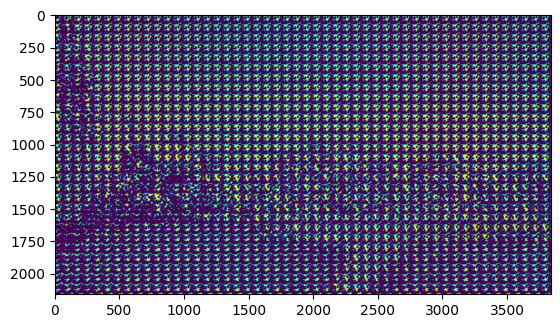

In [118]:
plt.imshow(filtered_arr)

In [110]:
print(filtered_arr[filtered_arr > 0.7].shape)

(1936491,)


In [111]:
filtered_arr = np.where(G_heatmap.detach().numpy() > threshold, G_heatmap.detach().numpy(), 0)

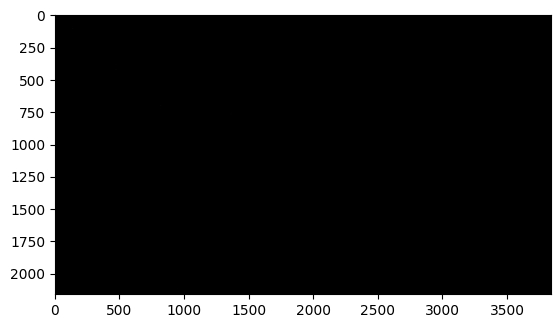

In [114]:
plt.imshow(filtered_arr, cmap='gray')


In [113]:
print(filtered_arr[filtered_arr > 0.7].shape)


(6,)


In [115]:
loss = f.binary_cross_entropy_with_logits(f.sigmoid(F_heatmap), f.sigmoid(G_heatmap))

In [116]:
loss

tensor(0.7455, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [120]:
loss = f.binary_cross_entropy_with_logits(f.sigmoid(torch.tensor(filtered_arr)), f.sigmoid(G_heatmap))


In [121]:
loss

tensor(0.7298, dtype=torch.float64)

In [122]:
P_heatmap.shape

torch.Size([224, 400])

In [123]:
P_width.shape

torch.Size([224, 400])